In [1]:
!pip install fastai
!pip install -U pyarrow

import numpy as np
import pandas as pd
import seaborn as sns

import requests
import ast
import os
import gc
import matplotlib.pyplot as plt

from fastai.vision import *
from fastai.metrics import error_rate, accuracy

Requirement already up-to-date: pyarrow in /usr/local/lib/python3.6/dist-packages (0.13.0)


In [2]:
# Will need to login to access the bucket. The following lines of code do just that
from google.colab import auth
auth.authenticate_user()

# List out all the files in the directory (Make sure that we are logged in)
gs_path = 'platform-ai-research/datasets/ProductNet/'
!gsutil ls gs://{gs_path}

gs://platform-ai-research/datasets/ProductNet/crawl-300d-2M.vec
gs://platform-ai-research/datasets/ProductNet/df2_clean_THRESHOLD_7
gs://platform-ai-research/datasets/ProductNet/df2_clean_THRESHOLD_7_2
gs://platform-ai-research/datasets/ProductNet/df2_clean_THRESHOLD_7_3
gs://platform-ai-research/datasets/ProductNet/labels_5m
gs://platform-ai-research/datasets/ProductNet/metadata.feather
gs://platform-ai-research/datasets/ProductNet/metadata_clean_0513
gs://platform-ai-research/datasets/ProductNet/taxonomy-with-ids.en-US.xls
gs://platform-ai-research/datasets/ProductNet/urls_20000
gs://platform-ai-research/datasets/ProductNet//
gs://platform-ai-research/datasets/ProductNet/images/
gs://platform-ai-research/datasets/ProductNet/mapped_label_temp_files/
gs://platform-ai-research/datasets/ProductNet/metadata_temp_files/


In [0]:
# # Next step is to download the images
# if (not os.path.exists('./images/')):
#     !mkdir 'images'

In [0]:
# from tqdm import tqdm

# imUrls = url_df.imUrl.tolist()
# asins = url_df.asin.tolist()

# # %%time
# for url_id in tqdm(zip(imUrls, asins)):
#     url = url_id[0] # url of image
#     asin = url_id[1] # asin of image
#     filename = './images/' + asin + '.jpg'
  
#     # also check if file exists. If it does, do not reload it!
#     if (not os.path.isfile(filename)):
#         try:
#             r = requests.get(url, allow_redirects=True)
#             open(filename, 'wb').write(r.content)
            
#         except Exception as e:
#             df2 = df2[df2.asin != asin]           # if missing, remove from dataset
#             with open("./missing.txt", "a") as f:
#                 f.write(asin+'\n')

In [0]:
# from PIL import Image

# for url_id in tqdm(zip(imUrls, asins)):
#     url = url_id[0] # url of image
#     asin = url_id[1] # asin of image
#     filename = './images/' + asin + '.jpg'
    
#     try:
#         img = Image.open(filename)
#     except Exception as e:
#         df2 = df2[df2.asin != asin]           # if missing, remove from dataset
#         with open("./missing_imgs.txt", "a") as f:
#             f.write(asin+'\n')

In [8]:
df2 = pd.read_feather('./df2_clean_THRESHOLD_7_3')

print(len(df2))

df2.head()

19448


,asin,label
0,B00318CL78,Baby Transport Accessories
1,B00G500248,Books
2,B005OGR3DM,Camera & Optic Accessories
3,B000QY9LOG,Agriculture
4,B000QY3GPQ,Camera & Optic Accessories


Rerun from here after cleaning the labels.

In [38]:
len(df2)

17612

In [0]:
np.random.seed(42)

tfms = get_transforms(max_lighting=0.1, max_zoom=1.05, max_warp=0.)

src = ImageDataBunch.from_df('./', 
                             df2, 
                             folder='images', 
                             suffix='.jpg', 
                             ds_tfms=tfms, 
                             size=224, 
                             bs=64).normalize(imagenet_stats)

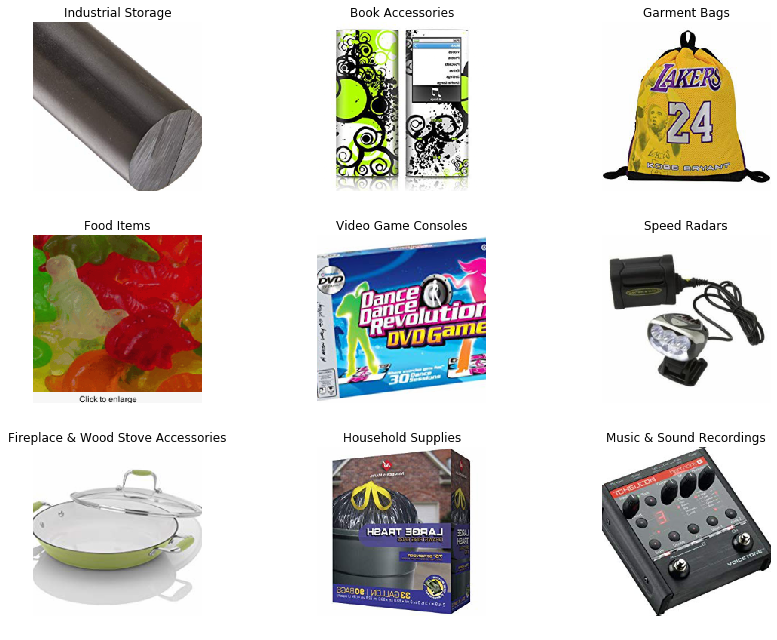

In [40]:
src.show_batch(rows=3, figsize=(12,9))

In [41]:
# print(src.classes)
len(src.classes),src.c

(142, 142)

In [42]:
len(src.train_ds), len(src.valid_ds), len(src.train_ds)+len(src.valid_ds)

(14090, 3522, 17612)

In [0]:
learn = cnn_learner(src, models.resnet50, metrics=error_rate)

In [44]:
gc.collect()

16086

In [45]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,3.686559,3.079100,0.717774,03:55
1,3.119719,2.801890,0.669790,03:51
2,2.689075,2.620952,0.636854,03:51
3,2.314228,2.587449,0.629472,03:52


In [0]:
# interp_train=None; interp_valid=None; gc.collect()

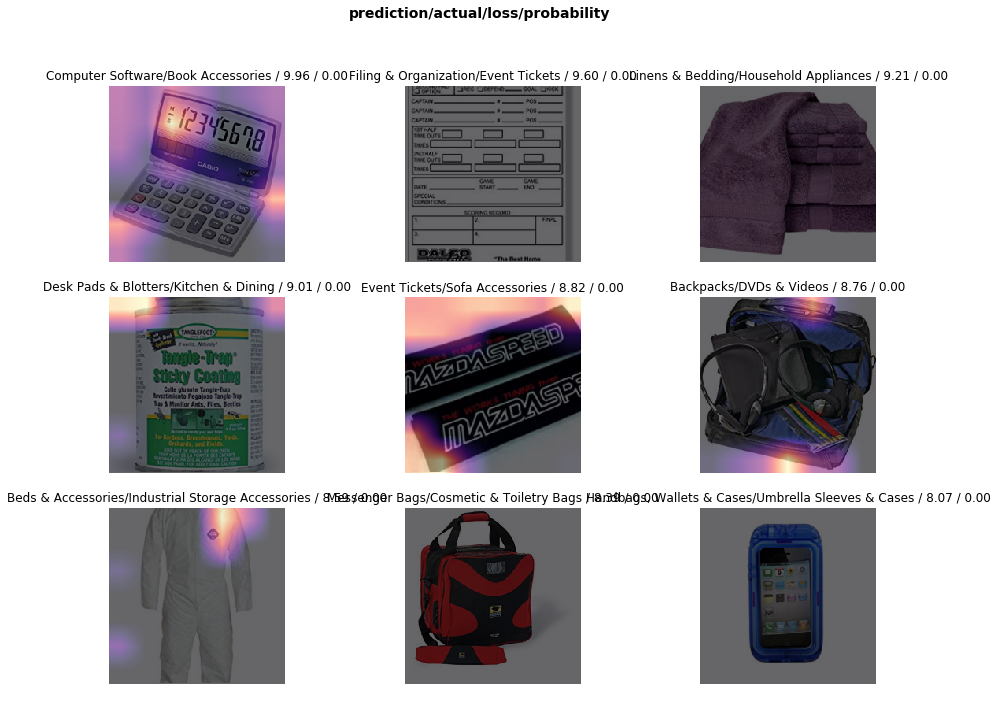

In [26]:
interp_train = ClassificationInterpretation.from_learner(learn, ds_type=1)
interp_train.plot_top_losses(9, figsize=(15,11))

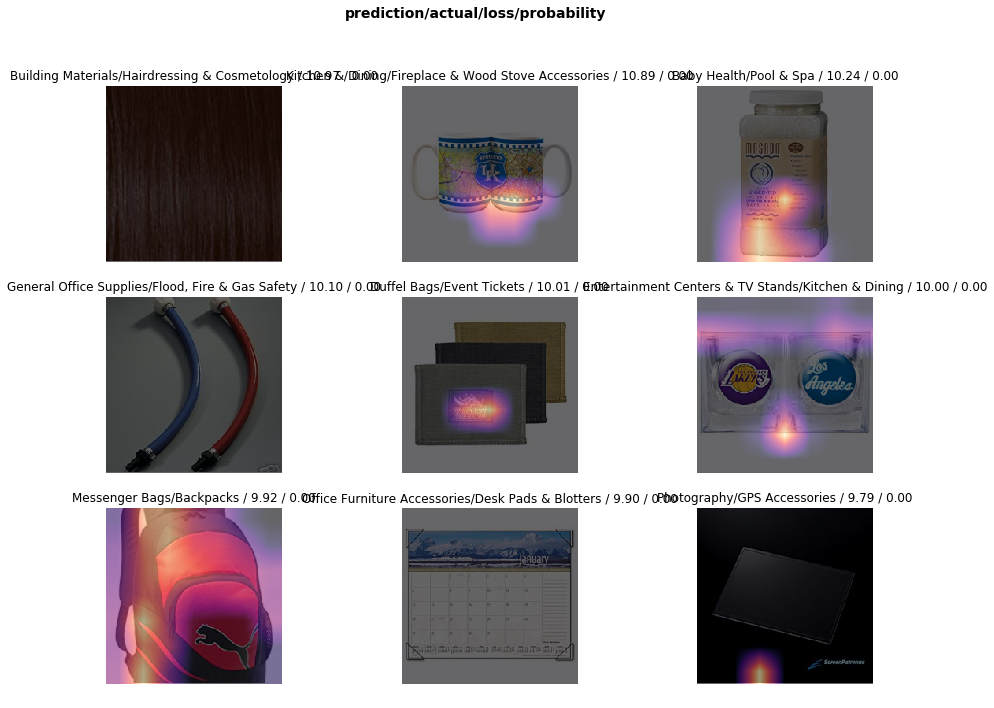

In [52]:
interp_valid = ClassificationInterpretation.from_learner(learn)
interp_valid.plot_top_losses(9, figsize=(15,11))

In [0]:
learn.unfreeze()

In [47]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,3.026212,3.339964,0.747019,05:02
1,3.096945,3.044508,0.721465,05:03
2,2.413970,2.654278,0.640545,05:03
3,1.655062,2.563829,0.616695,05:03


In [48]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


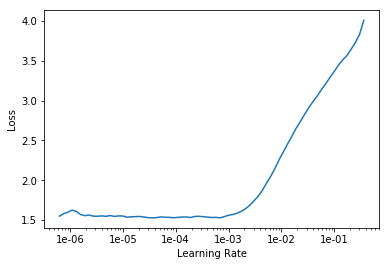

In [49]:
learn.recorder.plot()

In [51]:
learn.fit_one_cycle(4, 5e-4)

epoch,train_loss,valid_loss,error_rate,time
0,1.980276,3.444555,0.760363,05:02
1,2.363433,3.061197,0.694776,05:04
2,1.669480,2.736318,0.634299,05:03
3,1.089262,2.670550,0.622374,05:03


# Clean bad labels
Since some of the labels (not predictions) are wrong in the first place, we propose discarding the samples with wrong labels based on the losses by the model. We start with a threshold of 7 since the highest loss was around 10.

In [0]:
losses_train, idxs_train = interp_train.top_losses()
losses_valid, idxs_valid = interp_valid.top_losses()

In [0]:
THRESHOLD = 5

train_bad_labels_idx = []
valid_bad_labels_idx = []

for loss, idx in zip(losses_train, idxs_train):
    if loss > THRESHOLD:
        train_bad_labels_idx.append(idx)
        
for loss, idx in zip(losses_valid, idxs_valid):
    if loss > THRESHOLD:
        valid_bad_labels_idx.append(idx)

In [33]:
len(train_bad_labels_idx), len(valid_bad_labels_idx)

(1180, 656)

In [0]:
train = src.train_ds.x.items[:]
valid = src.valid_ds.x.items[:]

train_bad_asin = []
valid_bad_asin = []

for idx in train_bad_labels_idx:
    img_name_path = train[idx]
    asin = str(img_name_path).strip('.jpg').strip('/images')
    train_bad_asin.append(asin)
    
for idx in valid_bad_labels_idx:
    img_name_path = valid[idx]
    asin = str(img_name_path).strip('.jpg').strip('/images')
    valid_bad_asin.append(asin)    

In [35]:
len(train_bad_asin), len(valid_bad_asin)

(1180, 656)

In [36]:
print('len before:', len(df2))

df2 = df2[~df2['asin'].isin(train_bad_asin)].copy()
df2 = df2[~df2['asin'].isin(valid_bad_asin)].copy()

print('len after:', len(df2))

len before: 19448
len after: 17612


In [0]:
df2 = df2.reset_index(drop=True)

df2.to_feather('df2_clean_THRESHOLD_5_4')

In [84]:
# Push to GS
gs_path = 'platform-ai-research/datasets/ProductNet/'
file_name = 'df2_clean_THRESHOLD_7_3'

remote_file = gs_path + file_name
!gsutil cp {file_name} gs://{remote_file} 

Copying file://df2_clean_THRESHOLD_7_3 [Content-Type=application/octet-stream]...
/ [1 files][673.2 KiB/673.2 KiB]                                                
Operation completed over 1 objects/673.2 KiB.                                    
